# Quay Crane Scheduling Problem 

### Gurobi Library Optimization Was Used In this Model 

#### Import Optimization Library and Problem Inputs Data 

In [71]:
import gurobipy as gp
from gurobipy import *

# Problem data
p_tmp = [8,10,15,13,18,20]   # time required for each task
li = [1,2,3,4,5,6]    # location of each task
rk = [0, 0]    # earliest available time for each QC
l0k = [1, 2]     # starting position of each QC
lTk = [5, 6]      # final position of each QC

M = 100 #   a large constant
a1 = 1000   # weight for makespan
a2 = 0.5    # weight for total completion time

# Sets of indices
tasks = [
    'Start',
    'Task 1',
    'Task 2',
    'Task 3',
    'Task 4',
    'Task 5',
    'Task 6',
    'Finish',
]

In [72]:
t_tmp = [
    [ 3,  9, 18, 23, 35, 45, 53],
    [ 0,  6, 15, 20, 32, 42, 50],
    [ 6,  0,  9, 14, 26, 36, 44],
    [15,  9,  0,  5, 17, 27, 33],
    [20, 14,  5,  0, 12, 22, 30],
    [32, 26, 17, 12,  0, 10, 18],
    [42, 36, 27, 22, 10,  0,  8],
    [50, 44, 33, 30, 18,  8,  0],
]

# travel time from task i to task j for each QC
t = {
    (tasks[i], tasks[j]): t_tmp[i][j]
    for i in range(1, len(tasks)-1) for j in range(1, len(tasks)-1)
}

t_0 = {(k, j): t[tasks[l0k[k]], j] for k in range(len(rk)) for j in tasks[1:-1]}
t_T = {(k, i): t[i, tasks[lTk[k]]]
       for k in range(len(rk)) for i in tasks[1:-1]}


p = {
    tasks[i]: p_tmp[i-1] for i in range(1, len(tasks)-1)
}
phi=[(tasks[1],tasks[6]), (tasks[5],tasks[2])]
psi=[(tasks[1],tasks[2]),(tasks[2],tasks[3]),(tasks[3],tasks[4]),(tasks[4],tasks[5])]

### Initializing the model 

In [73]:
# Model
model = gp.Model("Quay Crane scheduling")


X = model.addVars(len(rk), tasks[:-1], tasks[1:], vtype=gp.GRB.BINARY, name='X')
Y = model.addVars(len(rk), lb=0, name='Y')
D = model.addVars(tasks[1:-1], lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS,name="D")
Z = model.addVars(tasks[1:-1], tasks[1:-1], vtype=GRB.BINARY, name="Z")
W = model.addVar(vtype=GRB.CONTINUOUS, name="W")

for k in range(len(rk)):
    model.addConstr(X[k, 'Start', 'Finish'] == 0)

\begin{equation}
    \text{Minimize } \alpha_1 W + \alpha_2 \sum_{k=1}^{K}Y_k
\end{equation}


In [74]:
# Objective
# No. 1
model.setObjective(a1 * W + a2 * quicksum(Y), GRB.MINIMIZE)

\begin{equation}
    Y_k \leq W \quad \forall k \in \{1, \dots, K\}
\end{equation}


In [75]:
# additional constraint For ensuring that i not equal j   

model.addConstrs((X[k,j,i] == 0 for i in tasks[1:] for j in tasks[:-1]
                  for k in range(len(rk)) if i == j))

## Evaluate the makespan
# No. 2
model.addConstrs(
    Y[k] <= W
    for k in range(len(rk))
)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>}

\begin{equation}
\sum_{j∈Ω}^{ } X_{0j}^k=1 \quad \forall k=1 \in \{1, ..., K\}
\end{equation}
\begin{equation}
\sum_{i∈Ω}^{ } X_{iT}^k=1 \quad \forall k=1 \in \{1, ..., K\}
\end{equation}

In [76]:
## Select First and Last Task for each QC.
# No. 3
model.addConstrs(
    quicksum(X[k,tasks[0], j] for j in tasks[1:-1]) == 1
    for k in range(len(rk))
)

# No. 4
model.addConstrs(
    quicksum(X[k, i,'Finish'] for i in tasks[1:-1]) == 1
    for k in range(len(rk))
)


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>}

$$\sum_{k} \sum_{i \in Ω} X_{ij}^{k}=1\quad \text{∀} j \in Ω$$





In [77]:
## Each task must be completed by exactly one QC.
# No. 5
model.addConstrs(
    quicksum(X[k, i, j] for k in range(len(rk)) for i in tasks[:-1]) == 1
    for j in tasks[1:-1]
)

{'Task 1': <gurobi.Constr *Awaiting Model Update*>,
 'Task 2': <gurobi.Constr *Awaiting Model Update*>,
 'Task 3': <gurobi.Constr *Awaiting Model Update*>,
 'Task 4': <gurobi.Constr *Awaiting Model Update*>,
 'Task 5': <gurobi.Constr *Awaiting Model Update*>,
 'Task 6': <gurobi.Constr *Awaiting Model Update*>}

$$\sum_{j}X_{ij}^{k}- \sum_{j} X_{j i}^{k}=0\quad \text {∀}i \in Ω , ∀k=1,...K,$$


In [78]:
## Flow balace constraint, guaranteeing that all tasks are
## performed in well-defined sequences.
# No. 6
model.addConstrs(
    quicksum(X[k,i,j] for j in tasks[1:] )
    - quicksum(X[k,j,i] for j in tasks[:-1])==0
    for k in range(len(rk)) for i in tasks[1:-1]
)


{(0, 'Task 1'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 2'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 3'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 4'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 6'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'Task 1'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'Task 2'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'Task 3'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'Task 4'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'Task 6'): <gurobi.Constr *Awaiting Model Update*>}

$$
D_i + t_{ij} + p_j - D_j \leq M \cdot (1 - X_{ij}^{k}) \quad \forall i,j \in \Omega, \forall k \in \{1,\dots,K\}
$$


In [79]:
# ## - Determine completion time for each task
# ## - Eliminate sub-tours.
# # No. 7
model.addConstrs(
    D[i] + t[i, j] + p[j] - D[j] <= M * (1 - X[k, i, j])
    for i in tasks[1:-1]
    for j in tasks[1:-1]
    for k in range(len(rk))
)

{('Task 1', 'Task 1', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 1', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 2', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 2', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 3', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 3', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 4', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 4', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 5', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 5', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 6', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 6', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 1', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 1', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 2', 0): <gurobi.Constr *Awaiting Model Updat

$$
D_i + p_j \leq D_j \quad \forall (i, j) \in \Phi
$$


In [80]:
## Task i should be completed before task j
# No. 8
for tuple in phi:
    i = 0
    j = 1
    while j < len(tuple):
      #  print(tuple[i], '~~', tuple[j])
        model.addConstr(D[tuple[i]] + p[tuple[j]] <= D[tuple[j]])
        i += 2
        j += 2

$$ D_i - D_j + p_j \leq M (1 - Z_{ij}) \quad \forall i, j \in \Omega $$


In [81]:
## Define Z_ij such that it starts is equals 1 only when task j starts after task i
# No. 9
model.addConstrs(
    D[i]-D[j]+p[j] <= M*(1-Z[i,j])
    for i in tasks[1:-1]
    for j in tasks[1:-1]
)

{('Task 1', 'Task 1'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 2'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 3'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 4'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 'Task 6'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 1'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 2'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 3'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 4'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 'Task 6'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 'Task 1'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 'Task 2'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 'Task 3'): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 'Task 4'): <gurobi.Constr *A

$$Z_{ij} + Z_{ji} = 1 \quad \forall (i, j) \in \Psi$$



In [82]:
## Guarantee that task i and j cannot be performed simultaneously when they shouldn't.
# No. 10
for tuple in psi:
    i = 0
    j = 1
    while j < len(tuple):
        model.addConstr(Z[tuple[i], tuple[j]] + Z[tuple[j], tuple[i]] == 1)
        i += 2
        j += 2

$$\sum\limits_{v=1}^k \sum\limits_{u \in \Omega} X_{uj}^v - \sum\limits_{v=1}^k \sum\limits_{u \in \Omega} X_{ui}^v \leq M (Z_{ij} + Z_{ji}) \quad \forall i, j \in \Omega,\quad l_i < l_j, \quad\forall k = 1, \dots, K$$


In [83]:
## Avoid interference between QCs
## assumming that l_i < l_j, and all cranes are ordered ascendingly
## (k1 is located before k2 etc...).
# No. 11
model.addConstrs(
    quicksum(X[v, u, j] for v in range(k+1) for u in tasks[1:-1])
    -
    quicksum(X[v,u,i] for v in range(k+1) for u in tasks[1:-1])
    <= M * (Z[i,j]+Z[j,i])
    for k in range(len(rk))
    for i in tasks[1:-1]
    for j in tasks[tasks.index(i)+1:-1]
)

{(0, 'Task 1', 'Task 2'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 1', 'Task 3'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 1', 'Task 4'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 1', 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 1', 'Task 6'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 2', 'Task 3'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 2', 'Task 4'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 2', 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 2', 'Task 6'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 3', 'Task 4'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 3', 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 3', 'Task 6'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 4', 'Task 5'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 4', 'Task 6'): <gurobi.Constr *Awaiting Model Update*>,
 (0, 'Task 5', 'Task 6'): <gurobi.Constr *Awaiting Model Updat

$$D_j + t_{jT}^k - Y_k \leq M (1 - X_{jT}^k)\quad\forall j \in \Omega,\quad \forall k = 1, \cdots, K$$



In [84]:
## Define the completion time of each QC.
# No. 12
model.addConstrs(
    D[j] + t_T[k, j] - Y[k] <= M * (1 - X[k, j,tasks[-1]])
    for j in tasks[1:-1]
    for k in range(len(rk))
)

{('Task 1', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 4', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 4', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 5', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 5', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 6', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 6', 1): <gurobi.Constr *Awaiting Model Update*>}

$$r_k - D_j + t_{0j}^k + p_j \leq M (1 - X_{0j}^k)\quad\forall j \in \Omega,\quad \forall k=1, \cdots, K$$



In [85]:
## Restrict earliest starting time of operations by each QC.
# No. 13
model.addConstrs(
    rk[k] - D[j] + t_0[k, j] + p[j] <= M * (1 - X[k, 'Start', j])
    for j in tasks[1:-1]
    for k in range(len(rk))
)
# No. 14 && No. 15 are constrained by variable definitions

{('Task 1', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 1', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 2', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 3', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 4', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 4', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 5', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 5', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 6', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Task 6', 1): <gurobi.Constr *Awaiting Model Update*>}

### Optimizing The Model and Get The Solutions 

In [86]:
model.Params.Method = 2  # Use Branch and Bound algorithm 
model.Params.NodeLimit = 100  # Maximum number of nodes to explore
model.setParam('TimeLimit', 700)

model.optimize()
for v in model.getVars(): 
    if v.x != 0: 
        print(f'{v.varName} = {v.x}')

Set parameter Method to value 2
Set parameter NodeLimit to value 100
Set parameter TimeLimit to value 700
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 206 rows, 143 columns and 1230 nonzeros
Model fingerprint: 0x06b5f6f7
Variable types: 9 continuous, 134 integer (134 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e-01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 49 rows and 24 columns
Presolve time: 0.02s
Presolved: 157 rows, 119 columns, 1008 nonzeros
Variable types: 9 continuous, 110 integer (110 binary)
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.341e+03
 Factor NZ  : 7.969e+03
 Factor Ops : 5.844e+05 (less than 1 second per iteration)
 Threads    : 1

                

### Sensitivity Analysis Calculations 

In [1]:
import gurobipy as gp
from gurobipy import *

# Initialize the sensitivity analysis parameter values
p_tmp_values = [[8, 10, 15, 13, 18, 20],[25, 20, 35, 32, 28, 30],[55, 40, 50, 47, 43, 49],[70, 75, 65, 68, 72, 69],

                [100, 75, 90, 83, 82, 85],[100, 95, 90, 92, 88, 87],[130, 125, 120, 117, 121, 123]]

model_variable_values = [] # Sorting Values For Variables name 
model_outputs = []   # Storing List for Objective Vlaues 
avg_processing_times = []  # Storing List for average processing times 
w_values = []      # Sorting Values for W values (total competion time)

# Looping and running the model 
for p_tmp in p_tmp_values:   
    
    li = [1,2,3,4,5,6,7]    # location of each task
    rk = [0, 0]    # earliest available time for each QC
    l0k = [1, 6]     # starting position of each QC
    lTk = [1, 6]      # final position of each QC

    M = 100000 #   a large constant
    a1 = 1000   # weight for makespan
    a2 = 0.5    # weight for total completion time

    # Sets of indices
    tasks = [
        'Start',
        'Task 1',
        'Task 2',
        'Task 3',
        'Task 4',
        'Task 5',
        'Task 6',
        'Finish',
    ]


    # In[22]:


    t_tmp = [
    [ 5, 11, 20, 25, 37, 47, 55],
    [ 1, 8, 17, 22, 34, 44, 52],
    [ 8, 1, 11, 16, 28, 38, 46],
    [17, 11, 1, 7, 19, 29, 35],
    [22, 16, 7, 1, 14, 24, 32],
    [34, 28, 19, 14, 1, 12, 20],
    [44, 38, 29, 24, 12, 1, 10],
    [52, 46, 35, 32, 20, 10, 1]
    ]

    # travel time from task i to task j for each QC
    t = {
       (tasks[i], tasks[j]): t_tmp[i][j]
       for i in range(1, len(tasks)-1) for j in range(1, len(tasks)-1)
    }

    t_0 = {(k, j): t[tasks[l0k[k]], j] for k in range(len(rk)) for j in tasks[1:-1]}
    t_T = {(k, i): t[i, tasks[lTk[k]]]
          for k in range(len(rk)) for i in tasks[1:-1]}


    p = {
       tasks[i]: p_tmp[i-1] for i in range(1, len(tasks)-1)
    }
    
    phi=[(tasks[1],tasks[6]), (tasks[5],tasks[2])]
    psi=[(tasks[1],tasks[2]),(tasks[2],tasks[3]),(tasks[3],tasks[4]),(tasks[4],tasks[5])]


    # ### Initializing the model 


    # Model
    model = gp.Model("Quay Crane scheduling")


    X = model.addVars(len(rk), tasks[:-1], tasks[1:], vtype=gp.GRB.BINARY, name='X')
    Y = model.addVars(len(rk), lb=0, name='Y')
    D = model.addVars(tasks[1:-1], lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS,name="D")
    Z = model.addVars(tasks[1:-1], tasks[1:-1], vtype=GRB.BINARY, name="Z")
    W = model.addVar(vtype=GRB.CONTINUOUS, name="W")

    for k in range(len(rk)):
        model.addConstr(X[k, 'Start', 'Finish'] == 0)

    # Objective
    # No. 1
    model.setObjective(a1 * W + a2 * quicksum(Y), GRB.MINIMIZE)


    # additional constraint For ensuring that i not equal j   

    model.addConstrs((X[k,j,i] == 0 for i in tasks[1:] for j in tasks[:-1]
                      for k in range(len(rk)) if i == j))

    ## Evaluate the makespan
    # No. 2
    model.addConstrs(
        Y[k] <= W
        for k in range(len(rk))
    )



    ## Select First and Last Task for each QC.
    # No. 3
    model.addConstrs(
        quicksum(X[k,tasks[0], j] for j in tasks[1:-1]) == 1
        for k in range(len(rk))
    )

    # No. 4
    model.addConstrs(
        quicksum(X[k, i,'Finish'] for i in tasks[1:-1]) == 1
        for k in range(len(rk))
    )



    ## Each task must be completed by exactly one QC.
    # No. 5
    model.addConstrs(
        quicksum(X[k, i, j] for k in range(len(rk)) for i in tasks[:-1]) == 1
        for j in tasks[1:-1]
    )


    ## Flow balace constraint, guaranteeing that all tasks are
    ## performed in well-defined sequences.
    # No. 6
    model.addConstrs(
        quicksum(X[k,i,j] for j in tasks[1:] )
        - quicksum(X[k,j,i] for j in tasks[:-1])==0
        for k in range(len(rk)) for i in tasks[1:-1]
    )


    # ## - Determine completion time for each task
    # ## - Eliminate sub-tours.
    # # No. 7
    model.addConstrs(
        D[i] + t[i, j] + p[j] - D[j] <= M * (1 - X[k, i, j])
        for i in tasks[1:-1]
        for j in tasks[1:-1]
        for k in range(len(rk))
    )


    ## Task i should be completed before task j
    # No. 8
    for tuple in phi:
        i = 0
        j = 1
        while j < len(tuple):
          #  print(tuple[i], '~~', tuple[j])
            model.addConstr(D[tuple[i]] + p[tuple[j]] <= D[tuple[j]])
            i += 2
            j += 2


    ## Define Z_ij such that it starts is equals 1 only when task j starts after task i
    # No. 9
    model.addConstrs(
        D[i]-D[j]+p[j] <= M*(1-Z[i,j])
        for i in tasks[1:-1]
        for j in tasks[1:-1]
    )



    ## Guarantee that task i and j cannot be performed simultaneously when they shouldn't.
    # No. 10
    for tuple in psi:
        i = 0
        j = 1
        while j < len(tuple):
            model.addConstr(Z[tuple[i], tuple[j]] + Z[tuple[j], tuple[i]] == 1)
            i += 2
            j += 2



    ## Avoid interference between QCs
    ## assumming that l_i < l_j, and all cranes are ordered ascendingly
    ## (k1 is located before k2 etc...).
    # No. 11
    model.addConstrs(
        quicksum(X[v, u, j] for v in range(k+1) for u in tasks[1:-1])
        -
        quicksum(X[v,u,i] for v in range(k+1) for u in tasks[1:-1])
        <= M * (Z[i,j]+Z[j,i])
        for k in range(len(rk))
        for i in tasks[1:-1]
        for j in tasks[tasks.index(i)+1:-1]
    )




    ## Define the completion time of each QC.
    # No. 12
    model.addConstrs(
        D[j] + t_T[k, j] - Y[k] <= M * (1 - X[k, j,tasks[-1]])
        for j in tasks[1:-1]
        for k in range(len(rk))
    )



    ## Restrict earliest starting time of operations by each QC.
    # No. 13
    model.addConstrs(
        rk[k] - D[j] + t_0[k, j] + p[j] <= M * (1 - X[k, 'Start', j])
        for j in tasks[1:-1]
        for k in range(len(rk))
    )
    # No. 14 && No. 15 are constrained by variable definitions


    # ### Optimizing The Model and Get The Solutions 


    model.Params.Method = 2  # Use Branch and Bound algorithm 
    model.Params.NodeLimit = 100  # Maximum number of nodes to explore
    model.setParam('TimeLimit', 700)

    model.optimize()

    
    
    variable_values = {}
    for v in model.getVars():
        if v.x != 0:
            variable_values[v.varName] = v.x

    # Calculate the average processing time
    avg_processing_time = sum(p_tmp) / len(p_tmp)

    # Get the W value
    w_value = model.getVarByName('W').x

    # Store the average processing time and W value
    avg_processing_times.append(avg_processing_time)
    w_values.append(w_value)

    # Store the objective value
    model_outputs.append(model.objVal)

    # Print the model variable values
    print(f"Model variable values for p_tmp values {p_tmp}:")
    for var_name, var_value in variable_values.items():
        print(f"{var_name} = {var_value}")

    # Print the objective value
    print(f"Objective value: {model.objVal}")
    print()
    
    

Restricted license - for non-production use only - expires 2024-10-28
Set parameter Method to value 2
Set parameter NodeLimit to value 100
Set parameter TimeLimit to value 700
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 206 rows, 143 columns and 1230 nonzeros
Model fingerprint: 0xa1908faa
Variable types: 9 continuous, 134 integer (134 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [5e-01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 272168.00000
Presolve removed 49 rows and 24 columns
Presolve time: 0.03s
Presolved: 157 rows, 119 columns, 1011 nonzeros
Variable types: 9 continuous, 110 integer (110 binary)
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
Barrier statistics:
 

In [2]:
print( avg_processing_times)
print(model_outputs)
print(w_values)

[14.0, 28.333333333333332, 47.333333333333336, 69.83333333333333, 85.83333333333333, 92.0, 122.66666666666667]
[97095.99999980428, 169162.0, 205191.0, 274257.9999991734, 368345.9999973596, 397371.4999988118, 533520.999999898]
[96.99999999980446, 169.0, 205.0, 273.99999999917407, 367.9999999973616, 396.99999999881237, 532.9999999998981]


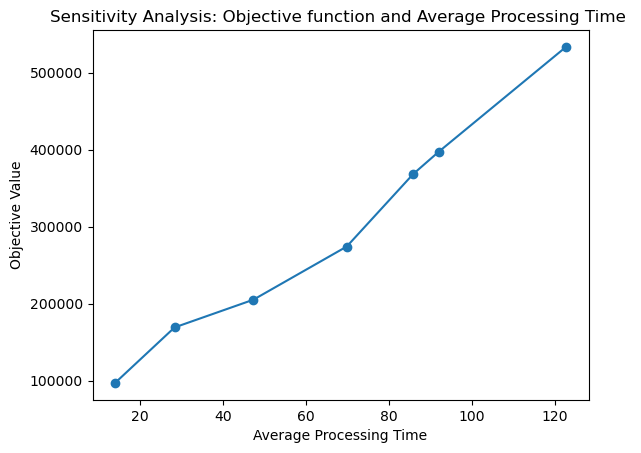

In [3]:
import matplotlib.pyplot as plt

plt.plot(avg_processing_times, model_outputs, 'o-')
plt.xlabel('Average Processing Time')
plt.ylabel('Objective Value')
plt.title('Sensitivity Analysis: Objective function and Average Processing Time ')
plt.show()

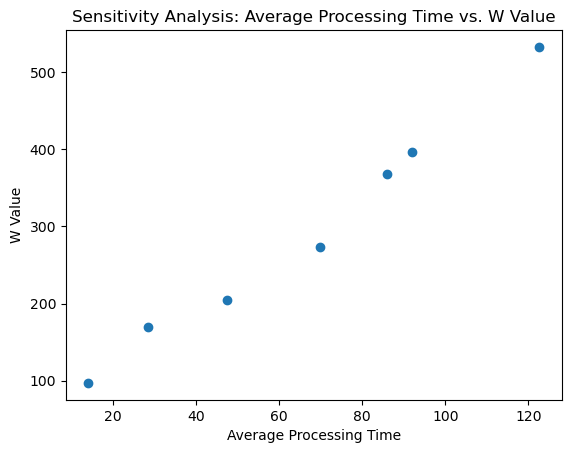

In [4]:
plt.scatter(avg_processing_times, w_values)
plt.xlabel('Average Processing Time')
plt.ylabel('W Value')
plt.title('Sensitivity Analysis: Average Processing Time vs. W Value')
plt.show()

Linear Regression Results:
Slope: 3907.752429385687
Intercept: 35339.91178251873
R-squared: 0.9828712837013794
P-value: 1.3117958307830728e-05
Standard Error: 230.7045311785866


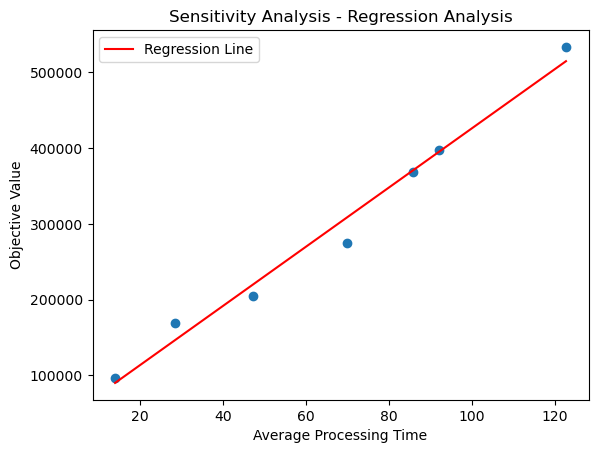

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Convert the lists to NumPy arrays
avg_processing_times = np.array(avg_processing_times)
model_outputs = np.array(model_outputs)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(avg_processing_times, model_outputs)

# Print the regression results
print("Linear Regression Results:")
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

# Plot the regression line
plt.scatter(avg_processing_times, model_outputs)
plt.plot(avg_processing_times, intercept + slope * avg_processing_times, 'r', label='Regression Line')
plt.xlabel('Average Processing Time')
plt.ylabel('Objective Value')
plt.title('Sensitivity Analysis - Regression Analysis')
plt.legend()
plt.show()


In [6]:
import statsmodels.api as sm

# Prepare the data
x = avg_processing_times  # Independent variable
y = model_outputs  # Dependent variable

# Add constant term to the independent variable
x = sm.add_constant(x)

# Fit the regression model
model = sm.OLS(y, x)
results = model.fit()

# Print the regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     286.9
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           1.31e-05
Time:                        15:45:27   Log-Likelihood:                -78.618
No. Observations:                   7   AIC:                             161.2
Df Residuals:                       5   BIC:                             161.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.534e+04   1.72e+04      2.052      0.0

C:\Users\MAHMOUD\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
